# Project_3: Linear Regressions
## Author: Wing Yan Sang
## Date: 11/5/2017

<p><a name="sections"></a></p>


## Sections

- <a href="#numeric">EDA of Numerics</a><br>
- <a href="#linear1">Linear Regression 1</a><br>
- <a href="#categorical">EDA of Categoricals</a><br>
- <a href="#categorica_engineering">Features Engineering of Select Categoricals</a><br>
- <a href="#linear2">Linear Regression 2</a><br>
- <a href="#VIF1">VIF Analysis of Linear Regression 2 Model</a><br>
- <a href="#linear3">Linear Regression 3</a><br>
- <a href="#linear4">Linear Regression 4</a><br>

#### Loading the packages to be used
from __future__ import print_function 
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from  statsmodels.genmod import generalized_linear_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns

In [93]:
#read in csv file and create data frame
train_sub = pd.read_csv("train_sub.csv")
train_sub = pd.DataFrame(train_sub)
pd.set_option('display.max_columns', None)
train_sub.head()

#drop columns: "X1stFlrSF, X2ndFlrSF, GarageQual, GarageCond, PavedDrive
train_sub = train_sub.drop(["X1stFlrSF", "X2ndFlrSF", "GarageQual", "GarageCond", "PavedDrive"], 1)
train_sub.head()


,MSZoning,Neighborhood,HouseStyle,OverallQual,YearBuilt,ExterQual,Foundation,BsmtQual,GrLivArea,FullBath,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea,SaleType,SaleCondition,SalePrice
0,RL,CollgCr,2Story,7,2003,Gd,PConc,Gd,1710,2,8,RFn,2,548,WD,Normal,208500.0
1,RL,Veenker,1Story,6,1976,TA,CBlock,Gd,1262,2,6,RFn,2,460,WD,Normal,181500.0
2,RL,CollgCr,2Story,7,2001,Gd,PConc,Gd,1786,2,6,RFn,2,608,WD,Normal,223500.0
3,RL,Crawfor,2Story,7,1915,TA,BrkTil,TA,1717,1,7,Unf,3,642,WD,Abnorml,140000.0
4,RL,NoRidge,2Story,8,2000,Gd,PConc,Gd,2198,2,9,RFn,3,836,WD,Normal,250000.0


In [94]:
#split into numeric and categorical features and observed values
X_num = train_sub[["GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea"]]
X_cat = train_sub.drop(["GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea", "SalePrice"],1)
y = train_sub[["SalePrice"]]


In [ ]:
#Inspect distribution of sales prices. Seems that log transformation can make the sales price more "normal".

mpl.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":y["SalePrice"], "log(price + 1)":np.log1p(y["SalePrice"])})
prices.hist()

#log transform the target:
y = np.log1p(y)
y

<p><a name="numeric"></a></p>

## EDA of Numeric Variables

EDA of the following Numeric Variables: "GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea"

In [96]:
#inspect summary of numeric variables
X_num.describe()

,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1515.463699,1.565068,6.517808,1.767123,472.980137
std,525.480383,0.550916,1.625393,0.747315,213.804841
min,334.000000,0.000000,2.000000,0.000000,0.000000
25%,1129.500000,1.000000,5.000000,1.000000,334.500000
50%,1464.000000,2.000000,6.000000,2.000000,480.000000
75%,1776.750000,2.000000,7.000000,2.000000,576.000000
max,5642.000000,3.000000,14.000000,4.000000,1418.000000


/Users/wingyansang/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


0.46899747732296548

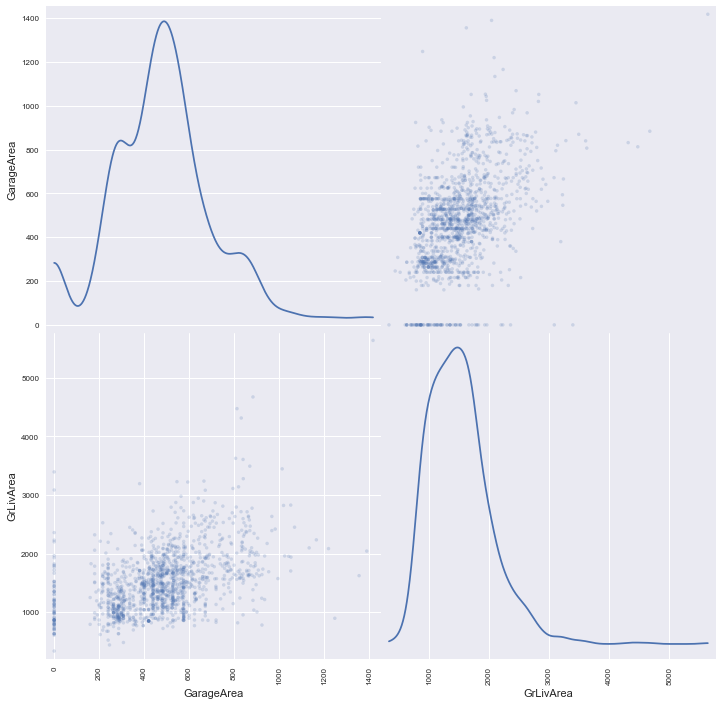

In [97]:
#Check for multicollinearity between GarageArea and GrLivArea. Scatter shows vague linear relationship. 
#Correlation is 0.46899

from pandas.tools.plotting import scatter_matrix
scatter_matrix(X_num[["GarageArea","GrLivArea"]], alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.savefig('num_scatter.png')
np.corrcoef(X_num["GarageArea"], X_num["GrLivArea"])[0, 1]

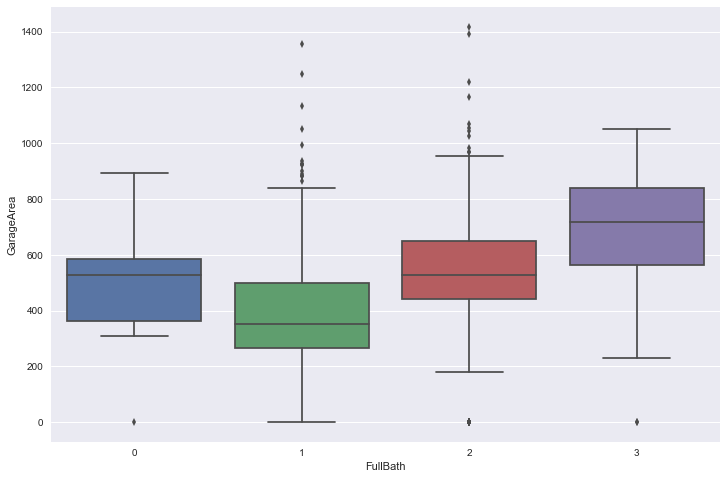

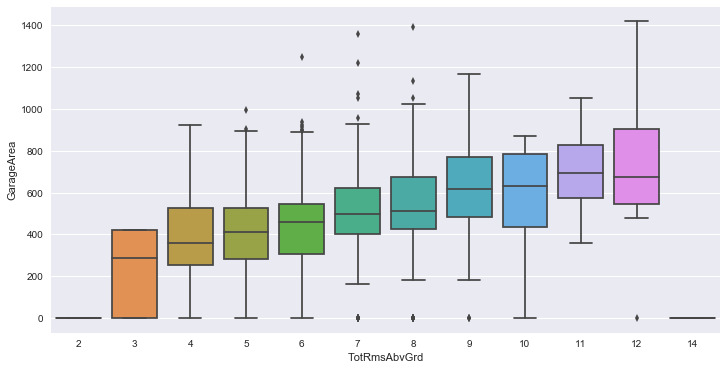

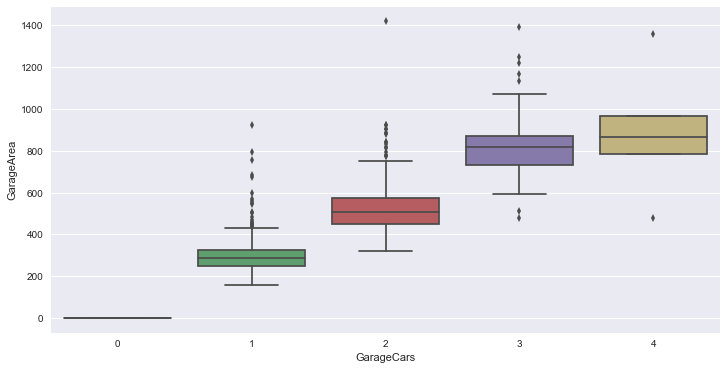

In [98]:
#check for multicollinearity between GarageArea with other variables (except GrLivarea) using boxplots.
#There does seem to be a linear relationship between Garage Area and these other variables.
#All seem pretty strong.
fig = plt.figure(figsize=(12, 8))
for i in range(1,4):
    sns.boxplot(y=X_num["GarageArea"], x=X_num.iloc[:,i])
    plt.show()

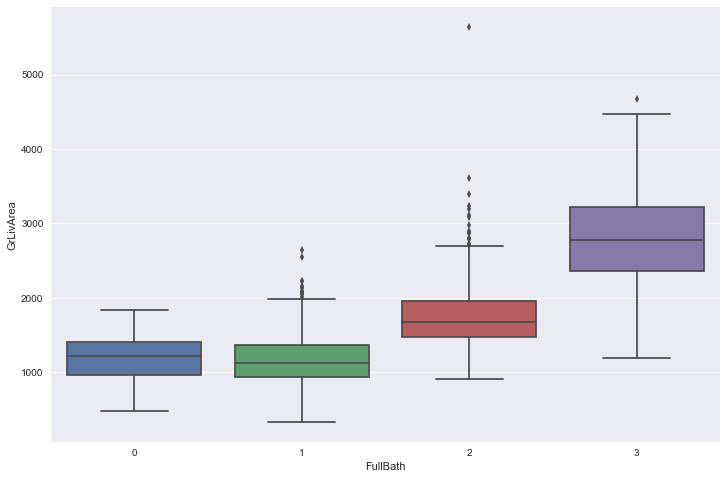

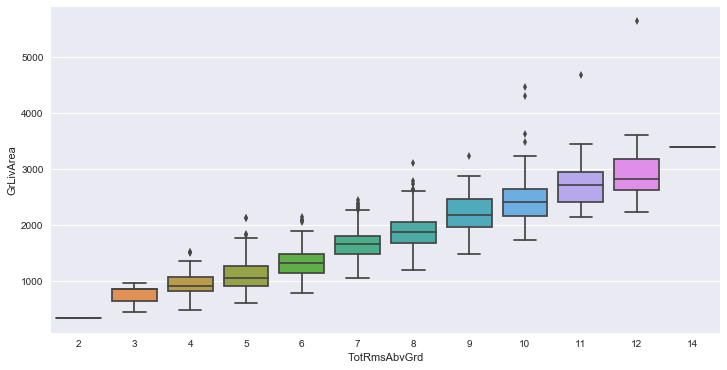

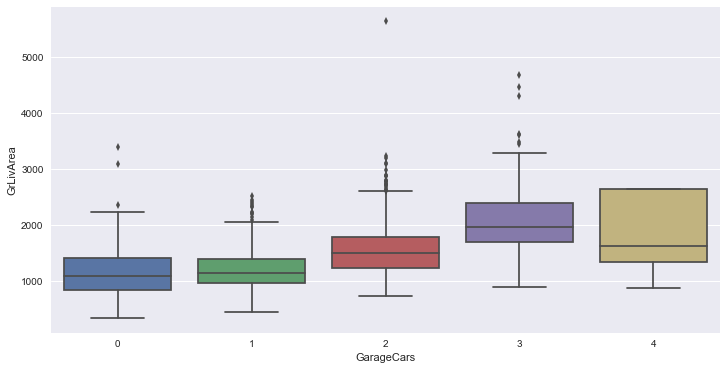

In [99]:
#check for multicollinearity between GrLivArea with other variables (except GrLivarea) using boxplots.
#There does seem to be a linear relationship between GrLiv Area and these other variables.
#TotRms and Full Bath are strongest.

fig = plt.figure(figsize=(12, 8))
for i in range(1,4):
    sns.boxplot(y=X_num["GrLivArea"], x=X_num.iloc[:,i])
    plt.show()

<p><a name="linear1"></a></p>
## Linear Regression 1

First linear regression with the following variables: "GrLivArea", "GarageCars", "GarageArea"

In [134]:
#Split into training and test sets

X = X_num[["GrLivArea", "GarageCars","GarageArea"]]

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [135]:
#Run linear model with just GrLivArea, GarageCars, GrLivArea
#RMSE goes up for test set. May have overfitted the model. Also the RMSE and R^2 results are not that good.
from sklearn.metrics import mean_squared_error
from math import sqrt

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted)
rms_train = sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))

colnames = X_train.columns
result = pd.DataFrame(ols.coef_)
result.columns = colnames.tolist()
result['intercept'] = ols.intercept_ 
result = result.transpose()
result.columns = ['coefficient']
result




Root mean squared error for train set: 0.234625
R^2 for train set: 0.662624
**************************************************
Root mean squared error for test set: 0.237823
R^2 for test  set: 0.601476


,coefficient
GrLivArea,0.000375
GarageCars,0.202718
GarageArea,0.000180
intercept,11.012599


In [136]:
#Performing same analysis as above using Statsmodel
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     762.1
Date:                Sun, 05 Nov 2017   Prob (F-statistic):          5.11e-274
Time:                        22:13:36   Log-Likelihood:                 36.007
No. Observations:                1168   AIC:                            -64.01
Df Residuals:                    1164   BIC:                            -43.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0126      0.022    494.314      0.0

In [137]:
X_test = sm.add_constant(X_test)
y_predicted_test = results.predict(X_test)

mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = sqrt(mean_squared_error(y_test, y_predicted_test))
print("Root mean squared error for test set: %f" %rms_test)


Root mean squared error for test set: 0.237823


<p><a name="categorical"></a></p>

## EDA of Categorical Variables

EDA of categorical variables to examine relationship with SalePrice and with each other. 


In [103]:
#View the Categorical Variables
X_cat.head()

,MSZoning,Neighborhood,HouseStyle,OverallQual,YearBuilt,ExterQual,Foundation,BsmtQual,GarageFinish,SaleType,SaleCondition
0,RL,CollgCr,2Story,7,2003,Gd,PConc,Gd,RFn,WD,Normal
1,RL,Veenker,1Story,6,1976,TA,CBlock,Gd,RFn,WD,Normal
2,RL,CollgCr,2Story,7,2001,Gd,PConc,Gd,RFn,WD,Normal
3,RL,Crawfor,2Story,7,1915,TA,BrkTil,TA,Unf,WD,Abnorml
4,RL,NoRidge,2Story,8,2000,Gd,PConc,Gd,RFn,WD,Normal


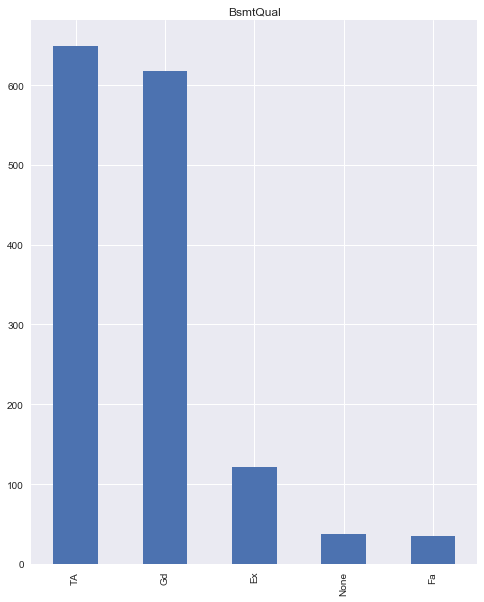

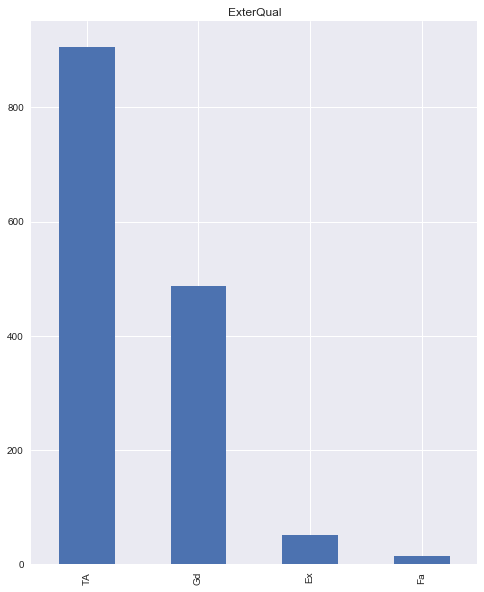

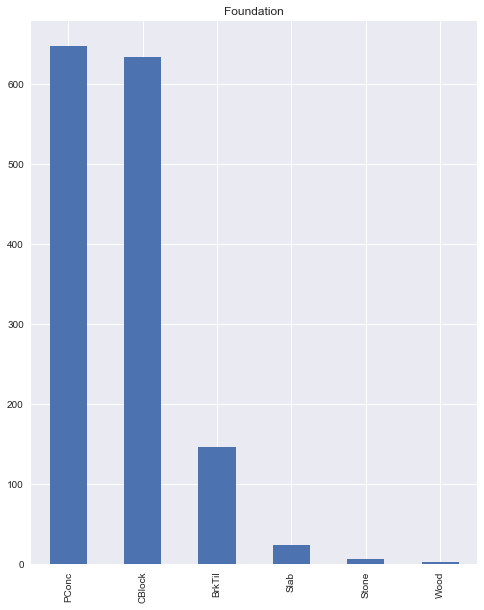

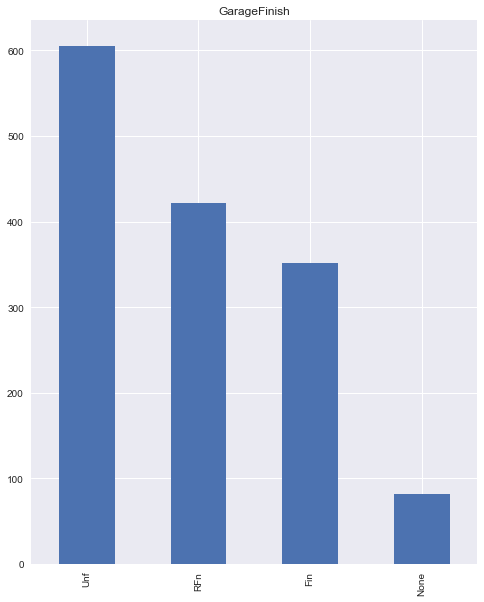

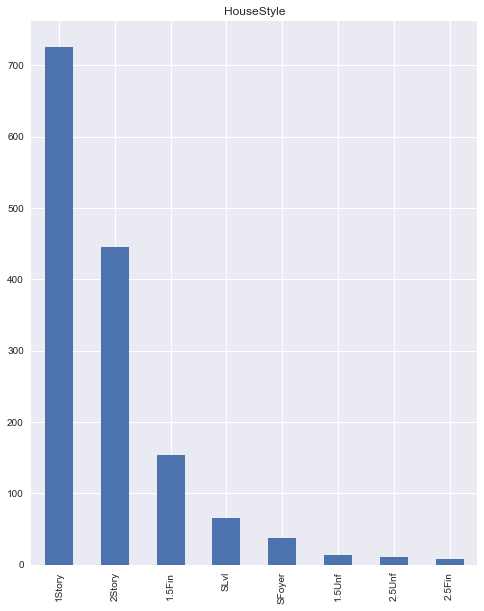

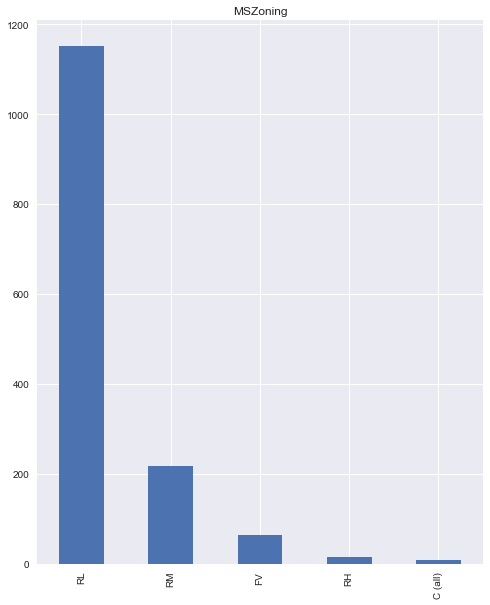

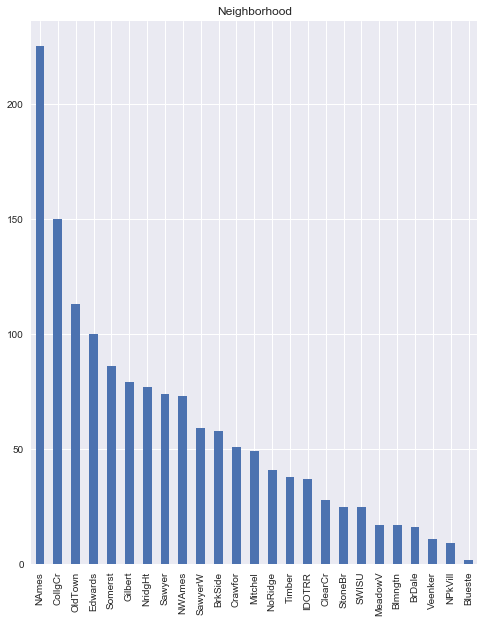

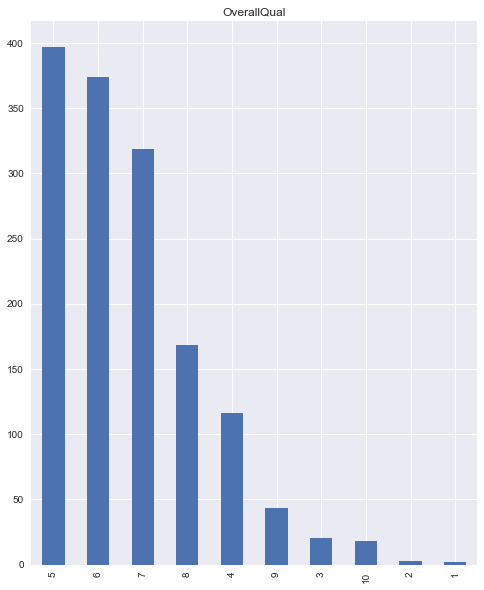

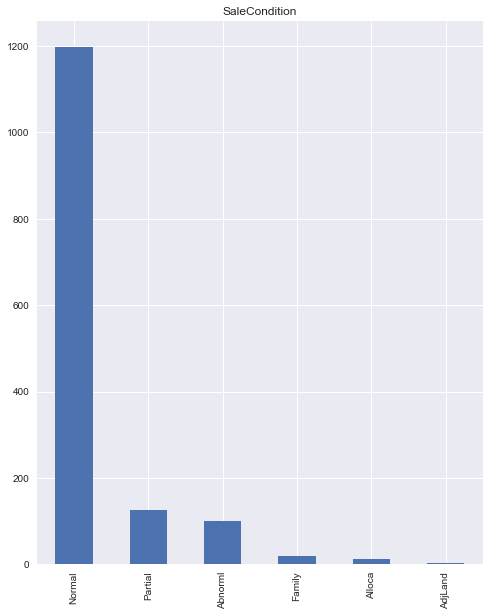

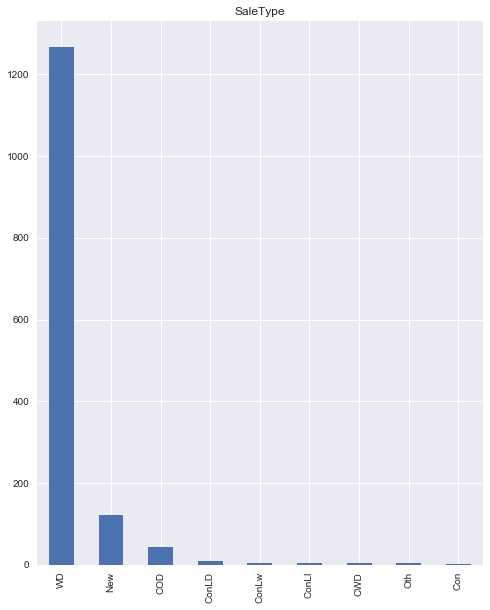

(array([   2.,    4.,    3.,    2.,    3.,    1.,   11.,    4.,   22.,
          26.,   54.,   42.,   26.,   22.,   35.,   23.,   58.,   47.,
         100.,   66.,   95.,   94.,   83.,   46.,   23.,   34.,   82.,
          88.,  206.,  158.]),
 array([ 1872. ,  1876.6,  1881.2,  1885.8,  1890.4,  1895. ,  1899.6,
         1904.2,  1908.8,  1913.4,  1918. ,  1922.6,  1927.2,  1931.8,
         1936.4,  1941. ,  1945.6,  1950.2,  1954.8,  1959.4,  1964. ,
         1968.6,  1973.2,  1977.8,  1982.4,  1987. ,  1991.6,  1996.2,
         2000.8,  2005.4,  2010. ]),
 <a list of 30 Patch objects>)

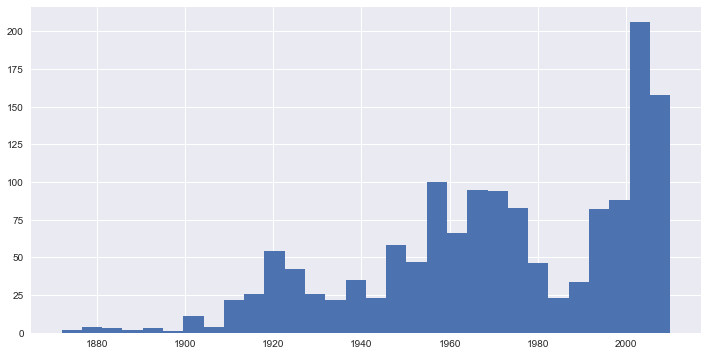

In [104]:
#Bar charts of the categorical variables
#For quality variables, the middle value (typical) dominates, then the second is good.
#GarageFinish is dominated by Unfinished and Rough Finish
#HouseStyle can be broken up into >=2Flr, <=1 1Flr, SplitLevel
#MSZoning dominated by Residential(Low and Medium Density)
#Will need to do further analysis on Neighborhood to see if it values can be combined.
#Sale Type/SaleCondition dominated by Warranty Deed and Normal
#Many homes built after 1990

for idx, col in zip(range(1, len(X_cat.columns)),X_cat.columns.sort_values()): 
    plt.figure(figsize=(8, 10)) 
    X_cat[col].value_counts().plot(kind='bar', )
    plt.title(col) 
    plt.show()
    
plt.hist(X_cat["YearBuilt"], bins=30) 
    


<p><a name="categorical_engineering"></a></p>

## EDA and Features Engineering of Select Categorical Variables

EDA and features engineering of the following categorical variables:
"Neighborhood", "OverallQual", "HouseStyle", "SaleCondition".


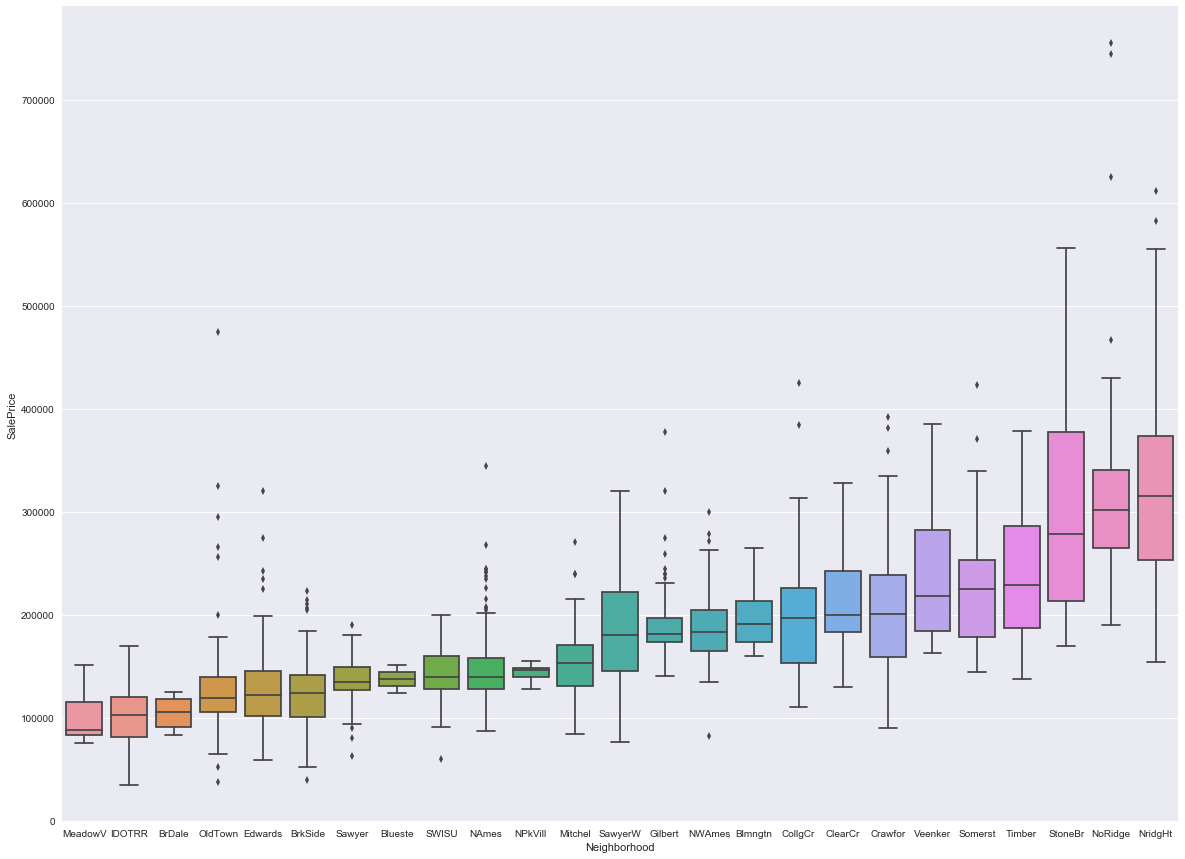

In [105]:
#Boxplot of sales price by neighborhood. 
#Seems like there are big ranges for neighborhoods at the top end of the market whereas ranges are smaller 
#at bottom neighborhoods. Also there are quite a few outliers. May have to remove them to prevent overfitting.

m = train_sub.groupby(['Neighborhood'])['SalePrice'].apply(np.median)
m.name = 'MEDIAN'
m = m.sort_values()
m.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_sub["SalePrice"], x=train_sub["Neighborhood"], order = m.index)

In [106]:
#Examine quartile ranges and group them
pd.qcut(m, 4)
x = pd.DataFrame(pd.qcut(m, 4))
x.columns.values[0] = "quartiles"
s = [i for i in range(1,5) for _ in range(6)]
s.insert(0,1)
x["Group"] = s
x.columns.values[1] = "Neigh_Group"
x['Neighborhood'] = x.index.tolist()

In [107]:
#Add Neigh_Group column to train_sub data frame. Count the frequency of each group. 
#Lower value homes most frequent. Higher valued homes least frequent.

new_df = pd.merge(train_sub, x, how='left', on = ["Neighborhood", "Neighborhood"])
new_df = new_df.drop("quartiles",1)
train_sub = new_df
train_sub.groupby("Neigh_Group").size()


Neigh_Group
1    415
2    369
3    398
4    278
dtype: int64

In [108]:
#Group HouseStyle variable by 1stFloor, 2ndFloor, and Split and count frequency. 1Story and 2Story close.

def hstyle(c):
    if c['HouseStyle'] == "1Story":
        return '1Story'
    elif c['HouseStyle'] in ["SFoyer", "SLvl"]:
        return 'Split'
    else:
        return '2Story'

train_sub['House_Group'] = train_sub.apply(hstyle, axis=1)
train_sub.groupby("House_Group").size()

House_Group
1Story    726
2Story    632
Split     102
dtype: int64

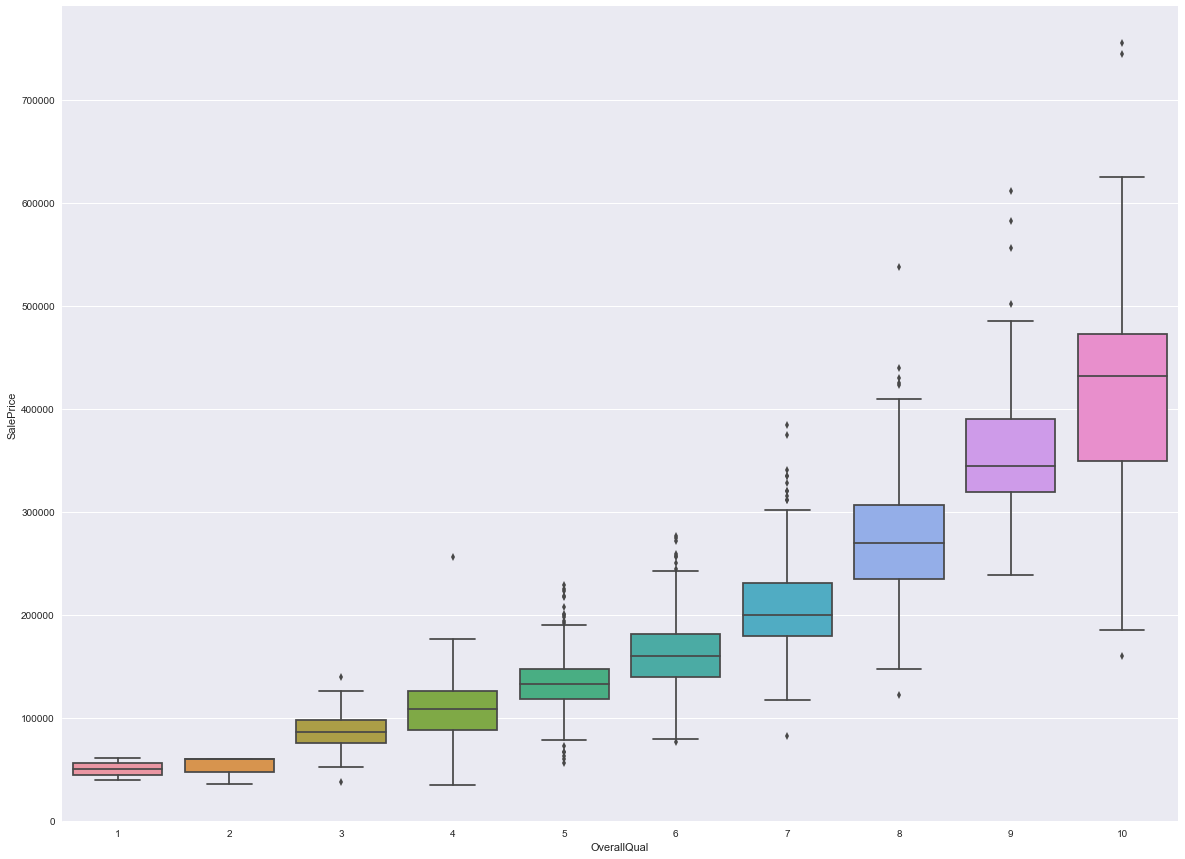

In [109]:
#Boxplot of sales price by OverallQual. As quality goes up, sales price goes up.
#Similar to Neighborhood analysis, there are bigger ranges the higher the quality. 
#Also there are quite a few outliers towards right side of chart.

n = train_sub.groupby(['OverallQual'])['SalePrice'].apply(np.median)
n.name = 'MEDIAN'
n = n.sort_values()
n.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_sub["SalePrice"], x=train_sub["OverallQual"], order = n.index)

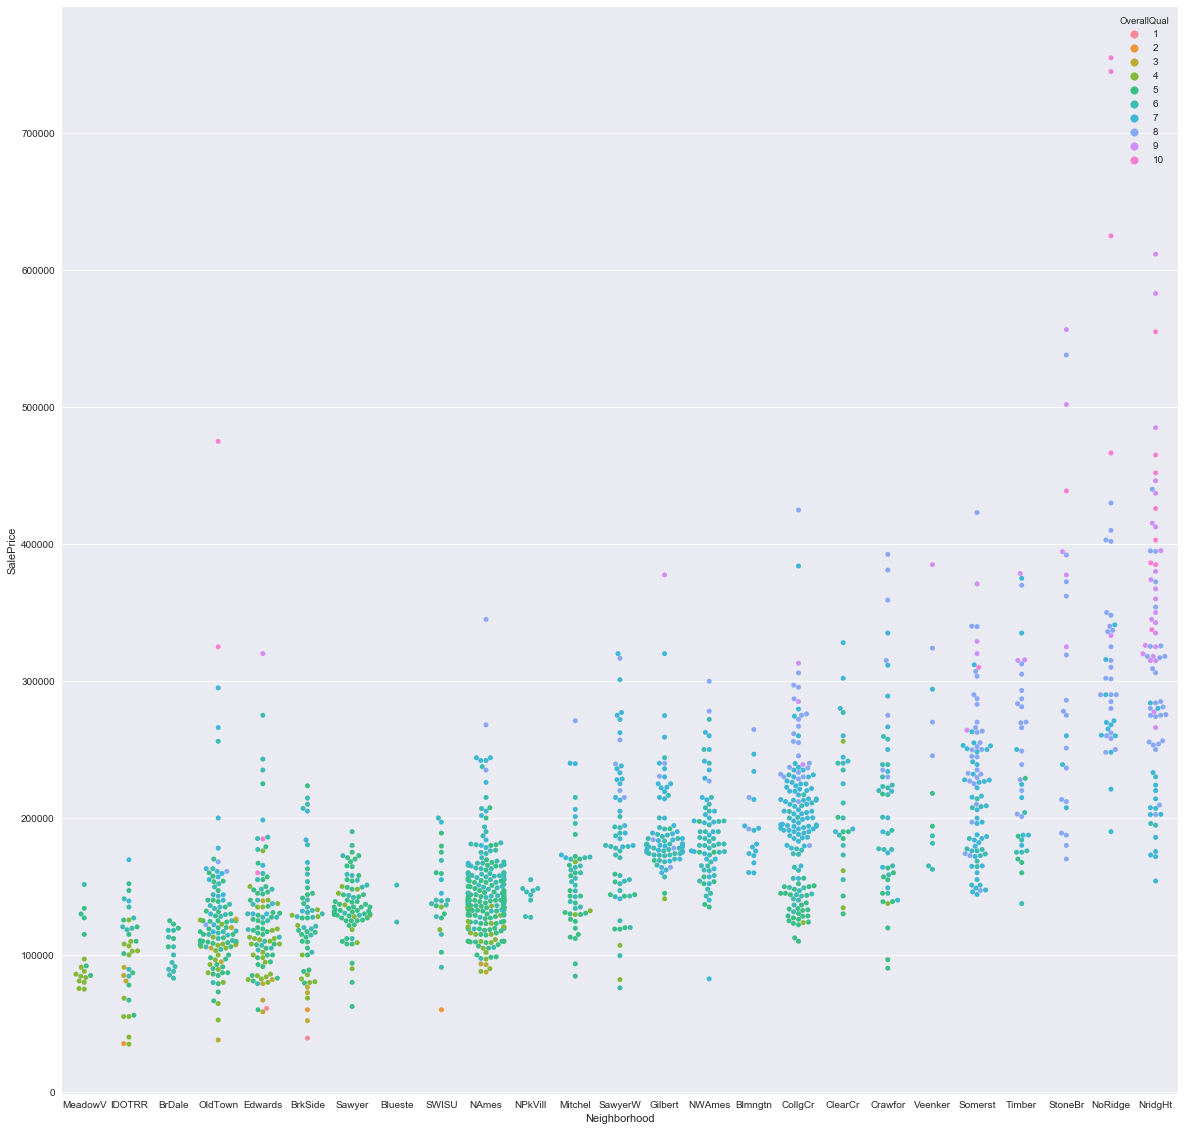

In [110]:
#Examine relationship between Neighborhood, OverallQual, and SalePrice. Lower quality (olive green, green) 
#corresponds to lower price and certain neigborhoods. Same for higher quality homes (violet, pinkish, light blue).

plt.figure(figsize=(20,20))
sns.swarmplot(x = 'Neighborhood', y = 'SalePrice', data=train_sub, hue='OverallQual',order = m.index)


In [111]:
#Crosstab also shows some relationship between the Neigh_Group and OverallQual

pd.crosstab(train_sub["Neigh_Group"], train_sub["OverallQual"])


OverallQual,1,2,3,4,5,6,7,8,9,10
Neigh_Group,,,,,,,,,,
1,2,2,17,83,182,94,27,3,1,4
2,0,1,3,27,152,135,42,9,0,0
3,0,0,0,6,56,122,169,41,4,0
4,0,0,0,0,7,23,81,115,38,14


In [112]:
#Examine the quantiles of OverallQual
qual_cut = pd.DataFrame(pd.qcut(n, 3))
qual_cut

,MEDIAN
OverallQual,
1,"(50149.999, 108000.0]"
2,"(50149.999, 108000.0]"
3,"(50149.999, 108000.0]"
4,"(50149.999, 108000.0]"
5,"(108000.0, 200141.0]"
6,"(108000.0, 200141.0]"
7,"(108000.0, 200141.0]"
8,"(200141.0, 432390.0]"
9,"(200141.0, 432390.0]"


In [113]:
#Add column that groups OverallQual into thirds

def overall_qual(c):
    if c['OverallQual'] <= 4:
        return 'Low'
    elif c['OverallQual'] > 7:
        return 'High'
    else:
        return 'Medium'

train_sub['Qual_Group'] = train_sub.apply(overall_qual, axis=1)
train_sub.groupby("Qual_Group").size()

Qual_Group
High       229
Low        141
Medium    1090
dtype: int64

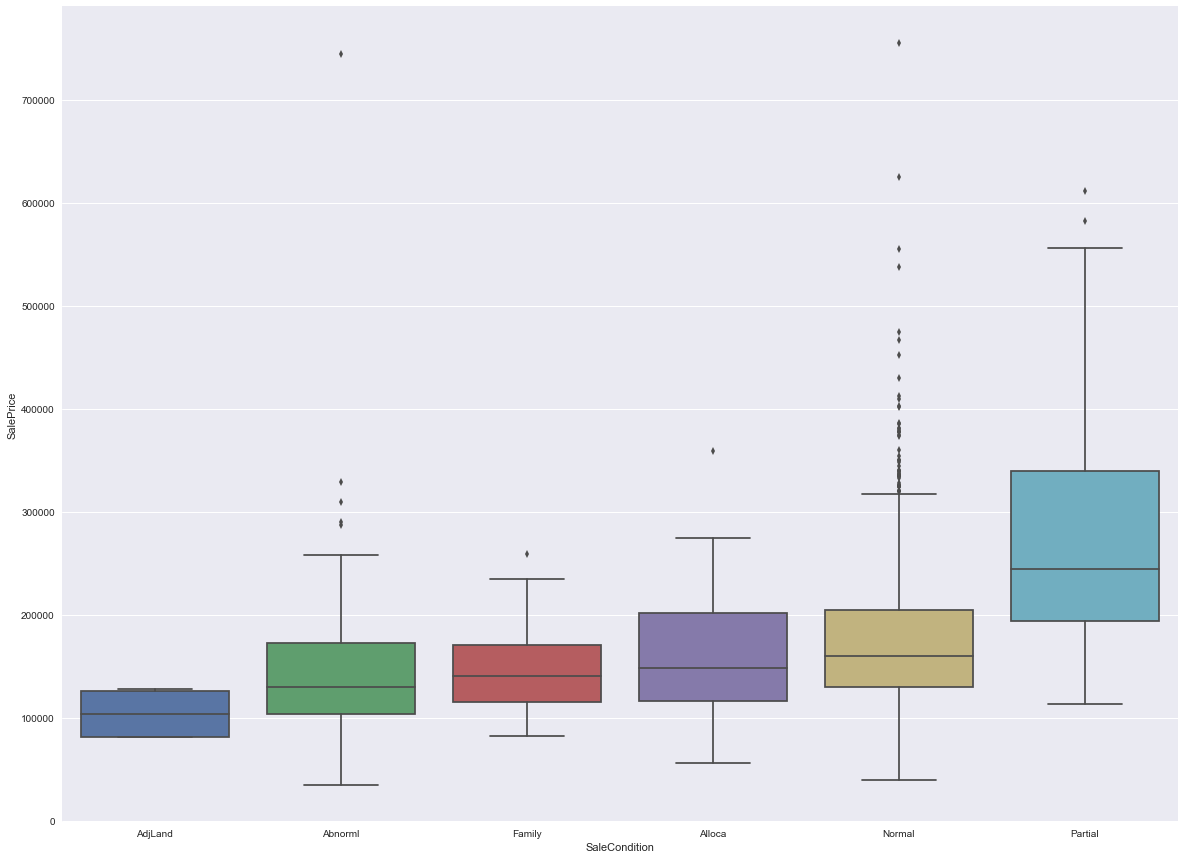

In [114]:
#Boxplot of sales price by SaleCondition. 

n2 = train_sub.groupby(['SaleCondition'])['SalePrice'].apply(np.median)
n2.name = 'MEDIAN'
n2 = n2.sort_values()
n2.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_sub["SalePrice"], x=train_sub["SaleCondition"], order = n2.index)

In [115]:
#Examine the quantiles of OverallQual
pd.qcut(n2, 3)

SaleCondition
AdjLand    (103999.999, 137000.0]
Abnorml    (103999.999, 137000.0]
Family     (137000.0, 152096.667]
Alloca     (137000.0, 152096.667]
Normal     (152096.667, 244600.0]
Partial    (152096.667, 244600.0]
Name: MEDIAN, dtype: category
Categories (3, interval[float64]): [(103999.999, 137000.0] < (137000.0, 152096.667] < (152096.667, 244600.0]]

In [116]:
#Add column that groups SaleCondition into thirds

def saleCond(c):
    if c['SaleCondition'] == "Partial":
        return 'Partial'
    else:
        return 'Non_partial'

train_sub['SaleCond_Group'] = train_sub.apply(saleCond, axis=1)
train_sub.groupby("SaleCond_Group").size()

SaleCond_Group
Non_partial    1335
Partial         125
dtype: int64

In [117]:
#dummify Neigh_Group
df = train_sub.copy()
hood = pd.get_dummies(df['Neigh_Group'], prefix='Neigh', prefix_sep='__')
hood = hood.drop('Neigh__1', axis=1)
hood.head()
df = pd.concat([df.drop('Neigh_Group', axis=1), hood], axis=1)



In [118]:
#dummify HouseStyle
df = df.copy()
style = pd.get_dummies(df['House_Group'], prefix='Style', prefix_sep='__')
style = style.drop('Style__1Story', axis=1)
df = pd.concat([df.drop('House_Group', axis=1), style], axis=1)



In [119]:
#dummify OverallQual
df = df.copy()
qual = pd.get_dummies(df['Qual_Group'], prefix='Qual', prefix_sep='__')
qual = qual.drop('Qual__Low', axis=1)
df = pd.concat([df.drop('Qual_Group', axis=1), qual], axis=1)

In [120]:
#dummify SaleCond
df = df.copy()
saleCond = pd.get_dummies(df['SaleCond_Group'], prefix='saleCond', prefix_sep='__')
saleCond = saleCond.drop('saleCond__Non_partial', axis=1)
df = pd.concat([df.drop('SaleCond_Group', axis=1), saleCond], axis=1)

<p><a name="linear2"></a></p>

## Linear Regression 2

Linear regression using the following variables: "GrLivArea", "Neighborhood", "OverallQual", 
"HouseStyle", "SaleCondition".

In [205]:
#Select five variables to perform linear regression
X = pd.concat([df[["GrLivArea"]],df[df.columns[-8:]]], axis = 1)

In [206]:
#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [207]:
#Fit 2nd linear model to train set and test against test set
#Results better than first model. RMSE does not change that much between train and test set.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted)
rms_train = sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))

colnames = X_train.columns
result = pd.DataFrame(ols.coef_)
result.columns = colnames.tolist()
result['intercept'] = ols.intercept_ 
result = result.transpose()
result.columns = ['coefficient']
result


Root mean squared error for train set: 0.187613
R^2 for train set: 0.784280
**************************************************
Root mean squared error for test set: 0.176133
R^2 for test  set: 0.781409


,coefficient
GrLivArea,0.000383
Neigh__2,0.132903
Neigh__3,0.275998
Neigh__4,0.380845
Style__2Story,-0.104413
Style__Split,0.053398
Qual__High,0.431581
Qual__Medium,0.205858
saleCond__Partial,0.086855
intercept,11.073877


In [208]:
#Performing same analysis as above using Statsmodel. Notice AIC and BIC better than 1st linear regression model.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     467.8
Date:                Sun, 05 Nov 2017   Prob (F-statistic):               0.00
Time:                        23:12:48   Log-Likelihood:                 297.18
No. Observations:                1168   AIC:                            -574.4
Df Residuals:                    1158   BIC:                            -523.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.0739      0.02

<p><a name="VIF1"></a></p>

## VIF Analysis of Variables in Linear Regression 2

The output of the Statsmodel makes it clear that multicollinearity may be an issue with the model. 
The following is a VIF analysis to assess which variables might be contributing the most to the VIF.

In [209]:
#Calculate the VIFs (not dependent on model fit). VIFs for GrLivArea and Qual_Medium are very high.
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train.drop("const", axis =1).values, i) for 
       i in range(X_train.drop("const", axis =1).shape[1])]
list(zip(vif, X_train.drop("const",axis=1).columns))


[(11.657907507048773, 'GrLivArea'),
 (2.1072341215436774, 'Neigh__2'),
 (2.2516691739372674, 'Neigh__3'),
 (2.7041679437982311, 'Neigh__4'),
 (2.6330442782466696, 'Style__2Story'),
 (1.1644425726035827, 'Style__Split'),
 (3.9318312582460955, 'Qual__High'),
 (7.1708452147145518, 'Qual__Medium'),
 (1.2474927132178639, 'saleCond__Partial')]

In [210]:
#Dropping GrLivArea reduces the VIF for all the variables. 
X_reduced = X_train.drop(["const","GrLivArea"], axis =1)
vif = [variance_inflation_factor(X_reduced.values, i) for 
       i in range(X_reduced.shape[1])]
print("VIF for all the variables:")
list(zip(vif, X_reduced.columns))

VIF for all the variables:


[(0.2613994039553858, 'Neigh__2'),
 (0.35154264866552626, 'Neigh__3'),
 (2.6235155969125885, 'Neigh__4'),
 (0.90096997347463881, 'Style__2Story'),
 (1.1543125781256203, 'Style__Split'),
 (2.4787227708627064, 'Qual__High'),
 (0.52045815261277018, 'Qual__Medium'),
 (1.244711582945448, 'saleCond__Partial')]

<p><a name="linear3"></a></p>

## Linear Regression 3

Linear regression with the GrLivArea dropped from the model.

In [211]:
#Let's rerun the linear regression without GrLivArea. Create train and test sets again.

X = df[df.columns[-8:]]

#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [212]:
#3rd Linear Regression. RMSE goes up again.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted)
rms_train = sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))

colnames = X_train.columns
result = pd.DataFrame(ols.coef_)
result.columns = colnames.tolist()
result['intercept'] = ols.intercept_ 
result = result.transpose()
result.columns = ['coefficient']
result

Root mean squared error for train set: 0.237776
R^2 for train set: 0.653502
**************************************************
Root mean squared error for test set: 0.222912
R^2 for test  set: 0.649880


,coefficient
Neigh__2,0.197969
Neigh__3,0.364657
Neigh__4,0.462777
Style__2Story,0.082265
Style__Split,0.061177
Qual__High,0.714616
Qual__Medium,0.283843
saleCond__Partial,0.108949
intercept,11.411383


In [213]:
#Performing same analysis as above using Statsmodel. Notice AIC and BIC better than 1st linear regression model
#but worse than 2nd model. However, we can be rest assured that multicollinearity is not an issue.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     273.2
Date:                Sun, 05 Nov 2017   Prob (F-statistic):          1.65e-260
Time:                        23:15:09   Log-Likelihood:                 20.428
No. Observations:                1168   AIC:                            -22.86
Df Residuals:                    1159   BIC:                             22.71
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.4114      0.02

<p><a name="eda_cars"></a></p>

## EDA and Feature Engineering of GarageCars

Before substituting GarageCars for GrLivArea, the following EDA analyses were performed to assess its 
relationship with the other variables. GarageCars is then dummified and assessed for its multicollinearity
with the other variables using a VIF analysis.

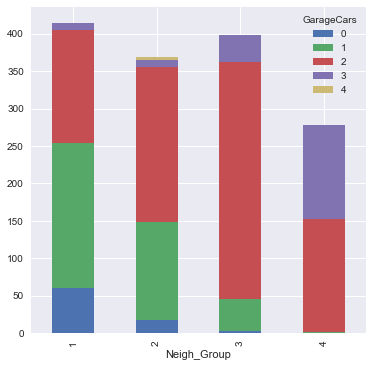

In [155]:
#What if we include GarageCars in the model? Does this improve it? First, let's see what it's correlation is 
#like with the other explanatory variables.

#GarageCars does seem to be correlated with the neighborhood groups.

cars_hood_table = pd.crosstab(index=train_sub["Neigh_Group"], 
                          columns=train_sub["GarageCars"])
cars_hood_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

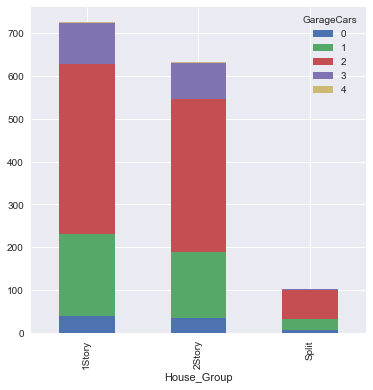

In [156]:
#Not so much with House_Group.
cars_house_table = pd.crosstab(index=train_sub["House_Group"], 
                          columns=train_sub["GarageCars"])
cars_house_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

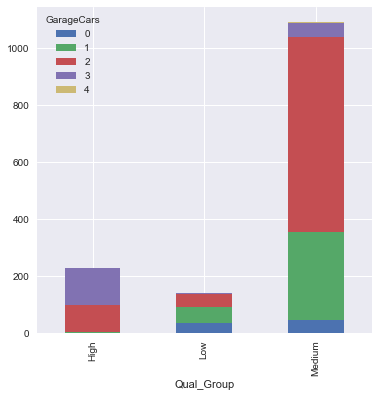

In [157]:
#High quality homes have more garages it seems on average
cars_quality_table = pd.crosstab(index=train_sub["Qual_Group"], 
                          columns=train_sub["GarageCars"])
cars_quality_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

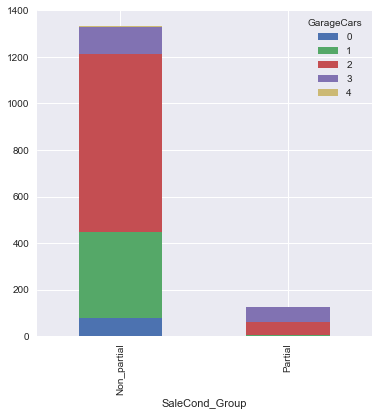

In [158]:
#Inconclusive relationship between GarageCars and SaleCond
cars_salecond_table = pd.crosstab(index=train_sub["SaleCond_Group"], 
                          columns=train_sub["GarageCars"])
cars_salecond_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

In [218]:
#Does substituting GarageCars for GrFlrArea reduce RMSE while not creating multicollinearity issues? First,
#let's dummify the variable
df = df.copy()
cars = pd.get_dummies(df['GarageCars'], prefix='Cars', prefix_sep='__')
cars = cars.drop('Cars__0', axis=1)
df = pd.concat([df, cars], axis=1)


In [220]:
#Split train_sub into train and test and fit 2nd linear model on train:

X = df[df.columns[-12:]]

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [222]:
#Checking VIFs. Amazing: all the VIFs are low. (Too good to be true????)
vif = [variance_inflation_factor(X.values, i) for 
       i in range(X.shape[1])]
print("VIF for all the variables:")
list(zip(vif, X.columns))

VIF for all the variables:


[(0.64688729083019769, 'Neigh__2'),
 (0.92020973762492697, 'Neigh__3'),
 (0.24491788321780528, 'Neigh__4'),
 (0.3625564761910271, 'Style__2Story'),
 (1.1578686507920701, 'Style__Split'),
 (3.9670673524779509, 'Qual__High'),
 (0.53643036798152199, 'Qual__Medium'),
 (1.3402751630642924, 'saleCond__Partial'),
 (0.93189245594883663, 'Cars__1'),
 (0.50256407771056766, 'Cars__2'),
 (3.3585388451606843, 'Cars__3'),
 (1.0292099707404789, 'Cars__4')]

<p><a name="linear4"></a></p>

## Linear Regression 4

Linear regression using the following variables: "GarageCars", "Neighborhood", "OverallQual", 
"HouseStyle", "SaleCondition".

In [224]:
#4th Linear Regression. RMSE goes down from 3rd model.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted)
rms_train = sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))

colnames = X_train.columns
result = pd.DataFrame(ols.coef_)
result.columns = colnames.tolist()
result['intercept'] = ols.intercept_ 
result = result.transpose()
result.columns = ['coefficient']
result

Root mean squared error for train set: 0.216524
R^2 for train set: 0.712673
**************************************************
Root mean squared error for test set: 0.204887
R^2 for test  set: 0.704213


,coefficient
Neigh__2,0.155527
Neigh__3,0.269773
Neigh__4,0.332867
Style__2Story,0.078484
Style__Split,0.047306
Qual__High,0.563890
Qual__Medium,0.232406
saleCond__Partial,0.069752
Cars__1,0.139001
Cars__2,0.310510


In [225]:
#Performing same analysis as above using Statsmodel. AIC and BIC numbers improve relative to 3rd model and 
#multi-collinearity doesn't seem to be an issue. 
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sun, 05 Nov 2017   Prob (F-statistic):          1.65e-302
Time:                        23:28:59   Log-Likelihood:                 129.78
No. Observations:                1168   AIC:                            -233.6
Df Residuals:                    1155   BIC:                            -167.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.2681      0.02